<a href="https://colab.research.google.com/github/penggenchang/CapitalOne_DataChallenge/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#plane_dir = "C:/Users/gench/suite2p/data/example/Raw_TIF/F1_output_001/suite2p/plane0"
# plane_dir = r"H:\suite2p\suite2p\plane0"
plane_dir = r"C:\plane0"

F = np.load(os.path.join(plane_dir, "F.npy"), mmap_mode="r")
iscell = np.load(os.path.join(plane_dir, "iscell.npy"))

n_rois   = F.shape[0]                         # all detected ROIs
n_cells  = int((iscell[:, 0] == 1).sum())     # ROIs labeled as cells
n_nonc   = n_rois - n_cells
ratio_cell = n_cells / n_rois if n_rois else float("nan")
## ROI detected
print(f"ROIs detected (all): {n_rois}")
print(f"Cells (accepted):    {n_cells}")
print(f"Non-cells:           {n_nonc}")
print(f"ROIs: {n_rois} | cells (accepted): {n_cells} | cell ratio: {ratio_cell:.3f}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\plane0/F.npy'

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#plane_dir = "C:/Users/gench/suite2p/data/example/Raw_TIF/F1_output_001/suite2p/plane0"
# plane_dir = r"H:\suite2p\suite2p\plane0"
plane_dir = "/content/drive/MyDrive/plane0"

F = np.load(os.path.join(plane_dir, "F.npy"), mmap_mode="r")
iscell = np.load(os.path.join(plane_dir, "iscell.npy"))

n_rois   = F.shape[0]                         # all detected ROIs
n_cells  = int((iscell[:, 0] == 1).sum())     # ROIs labeled as cells
n_nonc   = n_rois - n_cells

ratio_cell = n_cells / n_rois if n_rois else float("nan")
## ROI detected
print(f"ROIs detected (all): {n_rois}")
print(f"Cells (accepted):    {n_cells}")
print(f"Non-cells:           {n_nonc}")
print(f"ROIs: {n_rois} | cells (accepted): {n_cells} | cell ratio: {ratio_cell:.3f}")

ROIs detected (all): 791
Cells (accepted):    528
Non-cells:           263
ROIs: 791 | cells (accepted): 528 | cell ratio: 0.668


### Let's do the bundle work

In [10]:
def load_suite2p_plane(plane_dir):
    """Load core Suite2p arrays from a plane directory."""
    F     = np.load(os.path.join(plane_dir, "F.npy"), mmap_mode="r")
    Fneu  = np.load(os.path.join(plane_dir, "Fneu.npy"), mmap_mode="r")
    spks  = np.load(os.path.join(plane_dir, "spks.npy"), mmap_mode="r")
    iscl  = np.load(os.path.join(plane_dir, "iscell.npy"))
    stat  = np.load(os.path.join(plane_dir, "stat.npy"), allow_pickle=True)
    ops   = np.load(os.path.join(plane_dir, "ops.npy"), allow_pickle=True).item()
    return F, Fneu, spks, iscl, stat, ops

def is_cell_mask(iscell, min_prob=0.0):
    """
    iscell: shape (n_rois, 2) -> [accepted_flag, probability]
    Return boolean mask of ROIs considered 'cells'.
    """
    accepted = iscell[:, 0].astype(bool)
    prob_ok  = iscell[:, 1] >= min_prob
    return accepted & prob_ok

def neuropil_correct(F, Fneu, ops, default_r=0.7):
    """
    F_corr = F - r * Fneu, where r comes from ops['neucoeff'] if available.
    """
    r = ops.get("neucoeff", default_r)
    return F - r * Fneu, r

def compute_dff(Fcorr, win_percentile=8, win_size=500):
    """
    Simple ΔF/F using a rolling low-percentile baseline.
    Fcorr: (n_cells, n_frames)
    win_size in frames; adjust based on fs and biology.
    """
    n_cells, n_frames = Fcorr.shape
    F0 = np.empty_like(Fcorr, dtype=np.float32)
    pad = win_size // 2
    # pad by edge values to simplify windowing
    padded = np.pad(Fcorr, ((0,0),(pad,pad)), mode="edge")
    for t in range(n_frames):
        sl = slice(t, t + win_size)
        F0[:, t] = np.percentile(padded[:, sl], win_percentile, axis=1)
    dff = (Fcorr - F0) / np.maximum(F0, 1e-6)
    return dff, F0

def save_npz(path, **arrays):
    np.savez_compressed(path, **arrays)

# --------- Configure & run ----------
S2P_DIR = "/content/drive/MyDrive/plane0"##"C:/Users/gench/suite2p/data/example/Raw_TIF/F1_output_001/suite2p/plane0" # e.g., ".../suite2p/plane0"
OUT_NPZ = os.path.join(S2P_DIR, "clean_traces.npz")
MIN_PROB = 0.0        # keep Suite2p 'accepted' cells regardless of prob; set to 0.5 if you want stricter filtering
DO_DFF = True         # set False if you just want neuropil-corrected F

# Load
F, Fneu, spks, iscell, stat, ops = load_suite2p_plane(S2P_DIR)

# Filter to cells
mask = is_cell_mask(iscell, min_prob=MIN_PROB)
F, Fneu, spks = F[mask], Fneu[mask], spks[mask]
# Keep matching stat entries for the filtered cells
# (stat is an array of dicts; boolean indexing works)
stat = stat[mask]

# Neuropil subtraction
Fcorr, r_used = neuropil_correct(F, Fneu, ops)

# Optional ΔF/F
if DO_DFF:
    dff, F0 = compute_dff(Fcorr, win_percentile=8, win_size=500)
else:
    dff, F0 = None, None

# Save convenient bundle
save_npz(
    OUT_NPZ,
    F=F,
    Fneu=Fneu,
    Fcorr=Fcorr,
    spks=spks,
    iscell=iscell[mask],
    mask=mask,
    F0=(F0 if F0 is not None else np.array([])),
    dff=(dff if dff is not None else np.array([])),
    neucoeff=np.array([r_used]),
)

print(f"Saved: {OUT_NPZ}")
print(f"Shapes — F: {F.shape}, Fneu: {Fneu.shape}, Fcorr: {Fcorr.shape}, spks: {spks.shape}")
if DO_DFF:
    print(f"DFF shape: {dff.shape}, baseline F0 shape: {F0.shape}")
print(f"Used neuropil coefficient r = {r_used}")

Saved: /content/drive/MyDrive/plane0/clean_traces.npz
Shapes — F: (528, 1999), Fneu: (528, 1999), Fcorr: (528, 1999), spks: (528, 1999)
DFF shape: (528, 1999), baseline F0 shape: (528, 1999)
Used neuropil coefficient r = 0.7


### Using deconvoluted spikes for correlation

In [ ]:
spks = np.load(os.path.join(plane_dir, "spks.npy"))           # (n_rois, n_frames)
iscell = np.load(os.path.join(plane_dir, "iscell.npy"))
spks = spks[iscell[:,0].astype(bool)]                          # keep cells only

In [ ]:
PLANE_DIR = "C:/Users/gench/suite2p/data/example/Raw_TIF/F1_output_001/suite2p/plane0"
PROB_CUTOFF = None   # e.g., 0.5 to require iscell prob ≥ 0.5; None uses Suite2p accept flag only
ROLL_WIN_SEC = 60.0  # baseline window in seconds for ΔF/F
BASELINE_PCT = 8     # low percentile for baseline (5–10% common)
HP_HZ = 0.01         # high-pass cutoff in Hz (set None to skip)
DENSITY = 0.10       # keep top 10% absolute correlations as edges
REGRESS_GLOBAL = True
EXPORT_PREFIX = os.path.join(PLANE_DIR, "dff_connectivity")

# ======== Load ========
F    = np.load(os.path.join(PLANE_DIR, "F.npy"), mmap_mode="r")
Fneu = np.load(os.path.join(PLANE_DIR, "Fneu.npy"), mmap_mode="r")
isc  = np.load(os.path.join(PLANE_DIR, "iscell.npy"))
ops  = np.load(os.path.join(PLANE_DIR, "ops.npy"), allow_pickle=True).item()
MIN_F0 = 1e-6

fs = float(ops.get("fs", 10.0))      # Hz; default to 10 if missing
r  = float(ops.get("neucoeff", 0.7)) # neuropil coefficient

# Keep only accepted cells (optionally with a prob cutoff)
mask = isc[:,0].astype(bool) if PROB_CUTOFF is None else \
       (isc[:,0].astype(bool) & (isc[:,1] >= PROB_CUTOFF))
F    = np.asarray(F[mask],    dtype=np.float32)  # (n_cells, n_frames)
Fneu = np.asarray(Fneu[mask], dtype=np.float32)

# Neuropil subtraction
r = float(ops.get("neucoeff", 0.7))
Fcorr = F - r * Fneu

# --- Manuscript ΔF/F: percentile-10 baseline over the full session ---
# Robust to outliers; computed independently per neuron across all frames
F0 = np.percentile(Fcorr, 10, axis=1).astype(np.float32)         # (n_cells,)
F0 = np.maximum(F0, MIN_F0)                                      # floor to avoid division issues
dff = (Fcorr - F0[:, None]) / F0[:, None]                        # (n_cells, n_frames)

print("ΔF/F computed with session-wide 10th percentile baseline.")
print(f"Cells: {dff.shape[0]}, Frames: {dff.shape[1]}")

# (Optional) quick sanity checks
print("Median F0 (a.u.):", float(np.median(F0)))
print("ΔF/F percentile range:", np.percentile(dff, [1, 50, 99]))


ΔF/F computed with session-wide 10th percentile baseline.
Cells: 528, Frames: 1999
Median F0 (a.u.): 356.59368896484375
ΔF/F percentile range: [-0.74478736  0.80784515 26.36700642]


### Optional filtering"

In [ ]:
# ======== Optional preprocessing: high-pass + global signal regression ========
X = dff.copy()

from scipy import signal, stats
import networkx as nx
# High-pass (zero-phase Butterworth) to remove ultra-slow drifts
if HP_HZ is not None and HP_HZ > 0:
    wn = HP_HZ / (fs/2)
    wn = min(max(wn, 1e-6), 0.99)
    b, a = signal.butter(2, wn, btype="highpass")
    X = signal.filtfilt(b, a, X, axis=1, method="gust")

# Z-score per cell (helps equalize scales for correlation)
X = (X - X.mean(1, keepdims=True)) / (X.std(1, keepdims=True) + 1e-8)

# Global signal regression (mitigates shared/global fluctuations)
if REGRESS_GLOBAL:
    g = X.mean(axis=0, keepdims=True)                       # (1, T)
    proj = (X @ g.T) / (g @ g.T + 1e-8)                     # (N,1)
    X = X - proj @ g                                        # residuals


In [ ]:
Z = (dff - dff.mean(1, keepdims=True)) / (dff.std(1, keepdims=True) + 1e-8)

# Pearson correlation matrix (n_cells x n_cells)
R = np.corrcoef(Z)

In [ ]:
def sparsify(R, rule=("density", 0.10)):
    n = R.shape[0]
    iu = np.triu_indices(n, 1)
    mask = np.zeros_like(R, bool)
    if rule[0] == "density":
        density = float(rule[1])
        vals = np.abs(R[iu])
        k = int(np.floor(density * len(vals)))
        cut = np.partition(vals, -k)[-k] if k > 0 else np.inf
        mask[iu] = np.abs(R[iu]) >= cut
    elif rule[0] == "thr":
        thr = float(rule[1])
        mask[iu] = np.abs(R[iu]) >= thr
    mask |= mask.T
    np.fill_diagonal(mask, False)
    W = np.where(mask, R, 0.0)  # keep sign; switch to np.abs(R) if manuscript uses unsigned
    return W, mask

def graph_metrics(W, seed=0):
    G = nx.from_numpy_array(W)
    deg_w = dict(G.degree(weight='weight'))
    clust = nx.clustering(G, weight='weight')
    try:
        from networkx.algorithms.community import louvain_communities
        comms = louvain_communities(G, weight='weight', seed=seed)
    except Exception:
        from networkx.algorithms.community import greedy_modularity_communities
        comms = greedy_modularity_communities(G, weight='weight')
    node2comm = np.zeros(W.shape[0], int)
    for cid, C in enumerate(comms):
        for u in C: node2comm[u] = cid
    return G, np.array([deg_w[i] for i in range(W.shape[0])]), \
           np.array([clust[i] for i in range(W.shape[0])]), node2comm


In [ ]:
W, edge_mask = sparsify(R)
G, strength, clustering, community = graph_metrics(W, seed=0)

C:\Users\gench\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


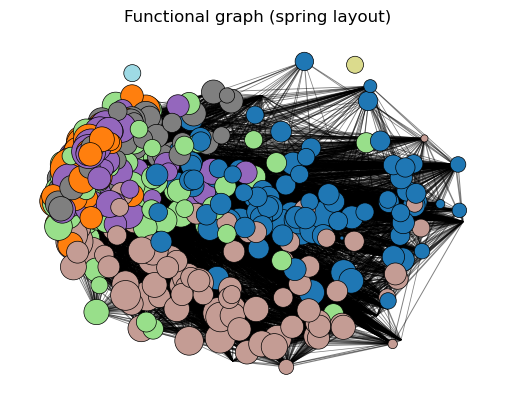

In [ ]:
import matplotlib.pyplot as plt

import networkx as nx

# Inputs you already have from earlier steps:
# G : networkx Graph with weights
# strength : np.array, node strength (sum of edge weights)
# community : np.array, integer community label per node

def draw_force_layout(G, strength, community, title="Functional graph (spring layout)"):
    pos = nx.spring_layout(G, weight='weight', seed=0)  # force-directed
    strengths = np.array([strength[i] for i in G.nodes()])
    sizes = 150 + 850 * (strengths / (strengths.max() + 1e-8))
    colors = [community[i] for i in G.nodes()]

    plt.figure()
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap='tab20', linewidths=0.5, edgecolors='k')
    nx.draw_networkx_edges(
        G, pos,
        width=[abs(d['weight'])*2 for *_, d in G.edges(data=True)],
        alpha=0.5
    )
    plt.axis('off'); plt.title(title)
    plt.show()

draw_force_layout(G, strength, community)

### Like in the draft

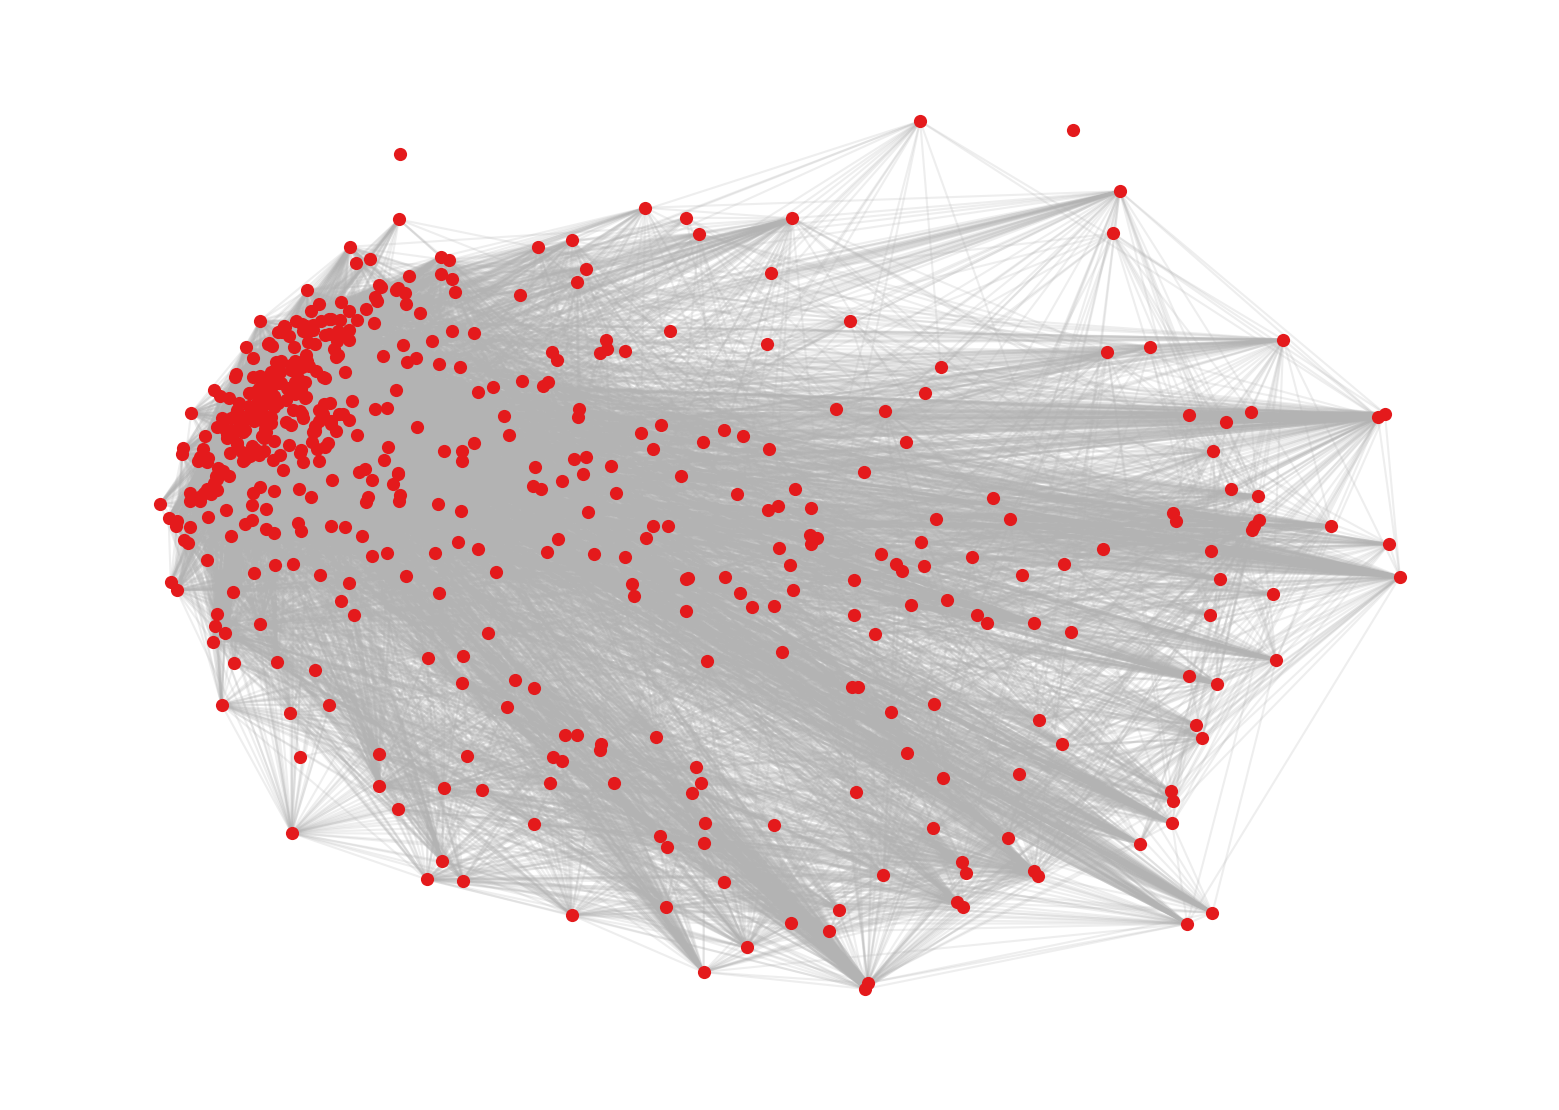

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def draw_red_nodes_gray_edges(
    G,
    pos=None,
    node_size=12,           # small red dots
    edge_alpha=0.25,        # faint edges
    edge_width=0.6,         # thin edges (use ~0.3–0.8)
    edge_gray=0.65,         # 0=black, 1=white
    k=None,                 # layout spacing; None lets NX choose
    seed=0,
    figsize=(6,4),
    dpi=300,
    scale_edges_by_weight=False
):
    """
    Force-layout visualization with uniform red nodes and thin gray edges.
    Set scale_edges_by_weight=True to scale widths by |weight|.
    """
    # Layout (reuse if you pass 'pos' in)
    if pos is None:
        pos = nx.spring_layout(G, weight='weight', seed=seed, k=k)

    plt.figure(figsize=figsize, dpi=dpi)

    # Edges first (so nodes sit on top)
    if scale_edges_by_weight:
        widths = [max(edge_width * abs(d.get('weight', 1.0)), 0.2) for *_, d in G.edges(data=True)]
    else:
        widths = edge_width

    nx.draw_networkx_edges(
        G, pos,
        edge_color=str(edge_gray),
        alpha=edge_alpha,
        width=widths
    )

    # Nodes on top: uniform red dots, no borders/labels
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color='#e41a1c',  # solid red
        linewidths=0
    )

    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    return pos  # return positions so you can reuse across plots


# G is your NetworkX graph with 'weight' on edges
pos = draw_red_nodes_gray_edges(
    G,
    node_size=10,           # tweak for density
    edge_alpha=0.22,
    edge_width=0.5,
    edge_gray=0.7,
    k=None, seed=0,
    figsize=(5,3.5), dpi=300,
    scale_edges_by_weight=False  # set True if you want subtle weight variation
)
